In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
from utils.functions import load_data
import matplotlib.pyplot as plt
from utils.plot_utils import plot_with_size, strip_right_top_axis, hit_miss_plot
import os

import numpy as np
import torch
%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)

In [2]:
os.chdir("..")

In [3]:
log_path = "log_dir/trained_models/pseudodata_no_tm"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model_no_tm = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

log_path = "log_dir/trained_models/pseudodata_hard_tm"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model_hard_tm = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

log_path = "log_dir/trained_models/pseudodata_soft_tm"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model_soft_tm = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

In [4]:
# Load data
(
    train_spikes,
    train_jaw,
    session_info_train,
    test_spikes,
    test_jaw,
    session_info_test,
) = load_data(model_no_tm)

time_vector = torch.arange(int(np.round((model_no_tm.opt.stop-model_no_tm.opt.start)/opt.dt / 0.001)))*model_no_tm.timestep + opt.start
filt_time = (
    model_no_tm.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model_no_tm.timestep
)[:, 0, 0] * model_no_tm.timestep

filt_data_train = model_no_tm.filter_fun1(train_spikes) / model_no_tm.timestep
filt_data_test = model_no_tm.filter_fun1(test_spikes) / model_no_tm.timestep

/tmp/ipykernel_291136/3014385958.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_no_tm.filter_fun1(torch.tensor(time_vector)[:, None, None]) / model_no_tm.timestep


threshold_based: tensor([0.0980, 0.9020])
threshold_based: tensor([0.2674, 0.7326])
threshold_based: tensor([0.2264, 0.7736])


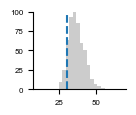

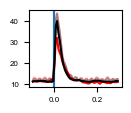

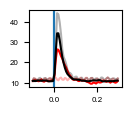

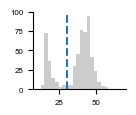

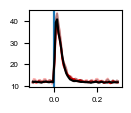

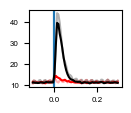

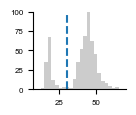

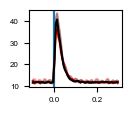

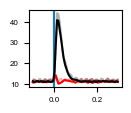

In [5]:
# Figure 2

classes=[0, 1, 2, 3]
colors=["red", "black", "blue", "green"]
seed = 1
for model_str, model in zip(["no_tm", "hard_tm", "soft_tm"], [model_no_tm, model_hard_tm, model_soft_tm]):
    model.opt.stim_onsets = [0] # This creates problem with input_spikes method
    with torch.no_grad():
        batch_size = 561
        opt.batch_size = batch_size
        stims = torch.ones(batch_size) * 4
        spikes, _, _, _ = model(stims)
        filt_model = model.filter_fun1(spikes) / model.timestep
    area_index = model.rsnn.area_index
    licks = filt_model[:,:,area_index==1].mean(2).max(0)[0]
    thr = 30
    trial_type_pred = licks>thr
    perc = trial_type_pred.unique(return_counts=True)[1]/model.opt.batch_size
    print("threshold_based:", perc)
    bins = np.arange(25) / 25 * 60 + 10

    with plt.rc_context({"font.size": 2 / 0.35}):
        fig, ax = plot_with_size(24, 20)
        points = filt_model[...,area_index==1].mean(2).max(0)[0].cpu().numpy()
        ax.axvline(thr, linestyle='--')
        ax.hist(points, bins =bins,alpha=0.2,density=False, color='black')
        plt.locator_params(axis="x", nbins=3)
        plt.locator_params(axis="y", nbins=4)
        plt.ylim(0,100)
        strip_right_top_axis(ax)

        fig.savefig(
            f"Figures/Figure2/{model_str}_hist.pdf", pad_inches=0, bbox_inches="tight"
        )
        for area in range(opt.num_areas):
            fig, ax = plot_with_size(24, 20)
            hit_miss_plot(
                ax,
                area,
                filt_model,
                filt_data_train,
                session_info_train,
                trial_type_pred,
                model,
                filt_time,
                colors=colors,
                classes=[0,1],
            )
            fig.savefig(
                f"Figures/Figure2/area{area}_{model_str}_plot.pdf", pad_inches=0, bbox_inches="tight"
            )